# **Aumente o Faturamento da Empresa com Previsão de Churn**

### Problema de Négocio

**A Empresa TopBank**

**Disclaimer:** O Contexto a seguir, é completamente fictício, a empresa, o contexto, o CEO, as perguntas de negócio existem somente na minha imaginação.

A TopBank é uma grande empresa de serviçõs bancários que atua na Europa. Dentre os servições desta empresa estão:

- Contas Bancárias
- Investimento
- Venda de Seguros

O principal produto da empresa é uma conta bancária, na qual o cliente pode depositar seu salário, fazer saques, depósitos e transferência para outras contas. Essa conta bancária não tem custo para o cliente e tem uma vigência de 12 meses, ou seja, o cliente precisa renovar o contrato dessa conta para continuar utilizando pelos próximos 12 meses.

Segundo o time de Analytics da TopBank, cada cliente que possui essa conta bancária retorna um valor monetário de 15% do valor do seu salário estimado, se esse for menor que a média e 20% se esse salário for maior que a média, durante o período vigente de sua conta. Esse valor é calculado anualmente. 

Por exemplo, se o salário mensal de um cliente é de RS 1.000,00 e a média de todos os salários do banco é de RS 800. A empresa, portanto, fatura RS 200 anualmente com esse cliente. Se esse cliente está no banco há 10 anos, a empresa já faturou RS 2.000,00 com suas transações e utilização da conta.

Nos últimos meses, o time de Analytics percebeu que a taxa de clientes cancelando suas contas e deixando o banco, atingiu números inéditos na empresa. Preocupados com o aumento dessa taxa, o time planejou um plano de ação para diminuir taxa de evasão de clientes.

**Objetivo:**

Reduzir a evasão de clientes.

**Questões a serem respondidas:**

- Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
- Qual a Performance do modelo em classificar os clientes como churns?
- Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
- Para quais clientes dar algum incentivo financeiro afim e evitar o churn e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  RS 10.000,00

**Os Dados do Desafio**

- **RowNumber:** O número da coluna
- **CustomerID:** Identificador único do cliente
- **Surname:** Sobrenome do cliente.
- **CreditScore:** A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography:** O país onde o cliente reside.
- **Gender:** O gênero do cliente.
- **Age:** A idade do cliente.
- **Tenure:** Número de anos que o cliente permaneceu ativo.
- **Balance:** Valor monetário que o cliente tem em sua conta bancária.
- **NumOfProducts:** O número de produtos comprado pelo cliente no banco.
- **HasCrCard:** Indica se o cliente possui ou não cartão de crédito.
- **IsActiveMember:** Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
- **EstimateSalary:** Estimativa do salário mensal do cliente.
- **Exited:** Indica se o cliente está ou não em Churn.

# 0.0 - Importações e Funções

## 0.1 - Importações

In [1]:
import pandas                as pd
import seaborn               as sns
import scikitplot            as skplt
import matplotlib.pyplot     as plt
import scikitplot            as skplt
import numpy as np

from xgboost                   import XGBClassifier
from imblearn.over_sampling    import SMOTE
from imblearn.under_sampling   import NearMiss
from sklearn.metrics           import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.tree              import DecisionTreeClassifier
from sklearn.preprocessing     import RobustScaler, MinMaxScaler
from sklearn.dummy             import DummyClassifier
  



import warnings
warnings.filterwarnings('ignore')

## 0.2 - Funções

In [2]:
# Função para calculo de métricas dos Modelos.
def ml_error(model_name,modelo):
    scores = cross_validate(modelo, X_train, y_train, cv=kfold ,scoring=('precision',
                                                                         'accuracy',
                                                                         'recall',
                                                                        'roc_auc',
                                                                        'average_precision'),return_train_score=False)
    return pd.DataFrame({'Model_Name':model_name,
                        'Acuracia':(scores['test_accuracy'].mean()),
                        'Precision': (scores['test_precision'].mean()),
                        'Recall': (scores['test_recall'].mean()),
                        'ROC_AUC':(scores['test_roc_auc'].mean()),
                        'Precision-Recall':(scores['test_average_precision'].mean())},index=[0])  
                                                                                      

In [3]:
# Função para agrupar a classe social de clientes.
def classe_social(coluna):
    if coluna <= 450:
        return 1
    elif coluna > 450 and coluna <=550:
        return 2
    elif coluna >550 and coluna <=650:
        return 3
    elif coluna >650 and coluna <=750:
        return 4
    else:
        return 5

In [4]:
# Função para agrupar o salário dos clientes.
def salario(coluna):
    if coluna <= 20000:
        return 1
    elif coluna > 20000 and coluna <=40000:
        return 2
    elif coluna >40000 and coluna <=60000:
        return 3
    elif coluna >60000 and coluna <=80000:
        return 4
    elif coluna > 80000 and coluna <=100000:
        return 5
    elif coluna >100000 and coluna <=120000:
        return 6
    elif coluna >120000 and coluna <=140000:
        return 7
    elif coluna >140000 and coluna <=160000:
        return 8
    elif coluna >160000 and coluna <=180000:
        return 9
    else:
        return 10

In [5]:
# Função para calcular a taxa de score por ano.
def credit_tenure(cols):
    credit = cols[0]
    tenure = cols[1]
    
    if tenure == 0:
        return tenure
    else:
        return credit/tenure

# 1.0 - DataFrame

## 1.1 Leitura do DataFrame

In [6]:
df = pd.read_csv('churn.csv')

In [7]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2.0 - Análise Descritiva

## 2.1 Análise descritiva dos dados

In [8]:
df.shape

(10000, 14)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [11]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# 3.0 - Feature Enginering

In [12]:
# Score dividido pela idade.
df['creditScore_per_age'] = df['CreditScore'] / df['Age']

In [13]:
# Score dividido pelos anos que ficou ativo.
df['creditScore_per_tenure'] = df[['CreditScore', 'Tenure']].apply(credit_tenure, axis=1)

In [14]:
# Score dividido pelos números de produtos comprados.
df['cred_prod'] = df['CreditScore'] / df['NumOfProducts']

In [15]:
# Idade menos o tempo que ficou ativo.
df['age_per_tenure'] = df['Age'] - df['Tenure']

In [16]:
# Tempo que ficou ativo dividido pelo número de produtos comprados.
df['tenure_per_numOfProducts'] = df['Tenure'] / df['NumOfProducts']

In [17]:
# Salário estimado vezes o tempo que permaneceu ativo.
df['Salary_per_score'] = df['EstimatedSalary'] / df['CreditScore']

In [18]:
# Salário dividido por idade.
df['Salary_per_age'] = df['EstimatedSalary'] / df['Age']

In [19]:
# Salário estimado vezes o tempo que permaneceu ativo.
df['Salary_per_tenure'] = df['EstimatedSalary'] * df['Tenure']

In [20]:
# Salário mais valor que possui na conta.
df['Salary_plus_balance'] = df['EstimatedSalary'] * df['Balance']

In [21]:
# Salário estimado vezes o número de produtos que comprou.
df['Salary_per_numOfProducts'] = df['EstimatedSalary'] * df['NumOfProducts']

In [22]:
# Criando faixas de Score.
df['score'] = df['CreditScore'].apply(classe_social)

In [23]:
# Criando Faixas de salário.
df['faixa_salario'] = df['EstimatedSalary'].apply(salario)

In [24]:
# Criando faixas de idade.
df['faixa_etaria'] = df['Age'].apply(lambda x: 'Jovem' if x<45 else ('meia idade' if x>=45 and x<60 else 'idoso'))

# 4.0 - Análise Exploratória

## 4.1 - Analise Univariada

### 4.1.1 Variavel Resposta

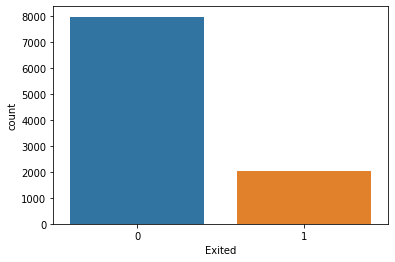

In [25]:
sns.countplot(x='Exited', data=df);

### 4.1.2 Variaveis Numericas

In [26]:
df_cat_col = df.select_dtypes(include='object')
df_num_col = df.select_dtypes(exclude='object')

In [27]:
df1_num_col = df_num_col.drop(['RowNumber','CustomerId'], axis=1)

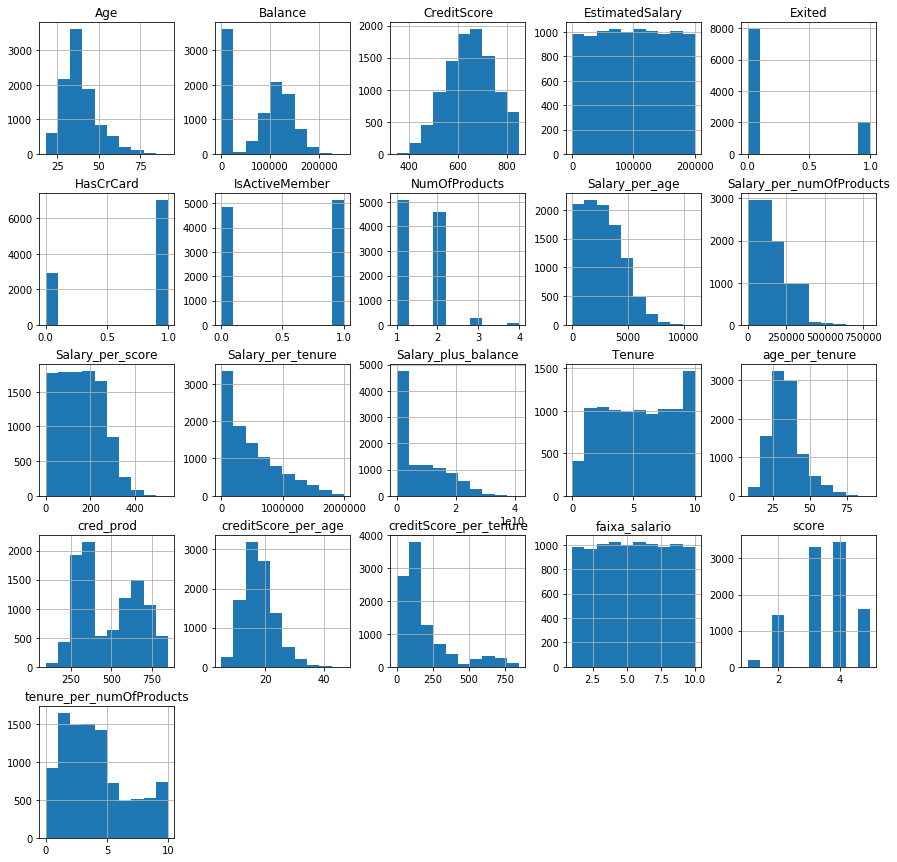

In [28]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df1_num_col.hist(ax=ax);

### 4.1.3 Variaveis Categoricas

#### Gráfico Países

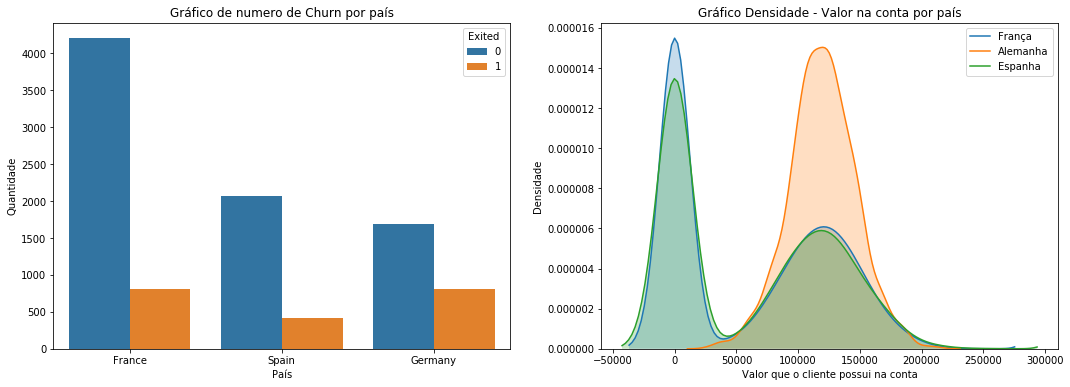

In [29]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Gráfico de numero de Churn por país')
sns.countplot(x='Geography', hue='Exited', data=df)
plt.xlabel('País'),plt.ylabel('Quantidade')


plt.subplot(1,2,2)
plt.title('Gráfico Densidade - Valor na conta por país')
sns.kdeplot(df[df['Geography'] == "France"]['Balance'],label='França', shade=True)
sns.kdeplot(df[df['Geography'] == 'Germany']['Balance'],label='Alemanha', shade=True)
sns.kdeplot(df[df['Geography'] == 'Spain']['Balance'],label='Espanha', shade=True)
plt.xlabel('Valor que o cliente possui na conta'),plt.ylabel('Densidade');

- O Banco possui mais clientes com a nacionalidade Francesa.
- Proporcionalmente os clientes Alemães parecem entrar mais em Churn.
- Os Clientes Alemães tem mais dinheiro na conta.

#### Gráficos de Densidade por gênero

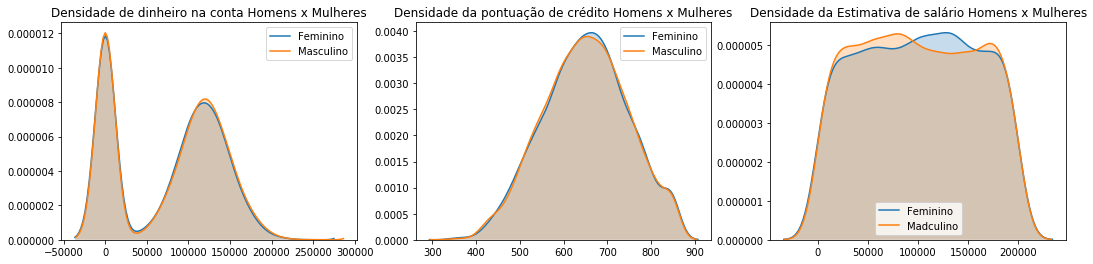

In [30]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.title('Densidade de dinheiro na conta Homens x Mulheres')
sns.kdeplot(df[df['Gender'] == "Female"]['Balance'],label='Feminino', shade=True)
sns.kdeplot(df[df['Gender'] == 'Male']['Balance'],label='Masculino', shade=True)

plt.subplot(1,3,2)
plt.title('Densidade da pontuação de crédito Homens x Mulheres')
sns.kdeplot(df[df['Gender'] == "Female"]['CreditScore'],label='Feminino', shade=True)
sns.kdeplot(df[df['Gender'] == 'Male']['CreditScore'],label='Masculino', shade=True)

plt.subplot(1,3,3)
plt.title('Densidade da Estimativa de salário Homens x Mulheres')
sns.kdeplot(df[df['Gender'] == "Female"]['EstimatedSalary'],label='Feminino', shade=True)
sns.kdeplot(df[df['Gender'] == 'Male']['EstimatedSalary'],label='Madculino', shade=True);

- As contas de Homens e Mulheres parecem ter o comportamento igual em relação ao valor de dinheiro na conta, Score e Salário.

#### Gráficos de Densidade por faixa etaria

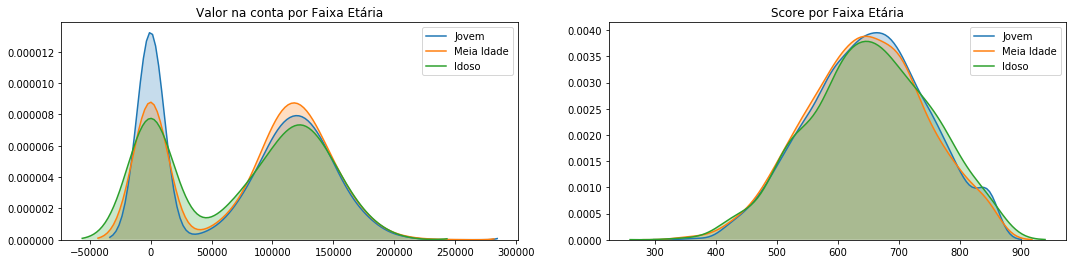

In [31]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.title('Valor na conta por Faixa Etária')
sns.kdeplot(df[df['faixa_etaria'] == 'Jovem']['Balance'],label='Jovem', shade=True)
sns.kdeplot(df[df['faixa_etaria'] == 'meia idade']['Balance'],label='Meia Idade', shade=True)
sns.kdeplot(df[df['faixa_etaria'] == 'idoso']['Balance'],label='Idoso', shade=True)

plt.subplot(1,2,2)
plt.title('Score por Faixa Etária')
sns.kdeplot(df[df['faixa_etaria'] == 'Jovem']['CreditScore'],label='Jovem', shade=True)
sns.kdeplot(df[df['faixa_etaria'] == 'meia idade']['CreditScore'],label='Meia Idade', shade=True)
sns.kdeplot(df[df['faixa_etaria'] == 'idoso']['CreditScore'],label='Idoso', shade=True);

- O Valor na conta parece ser igual independente da idade, porém existem mais Jovens com um valor menos na conta do que pessoas de meia idade e idosos.

- O Score parece ser independente da idade.


#### Churn por país de acordo com o tempo ativo

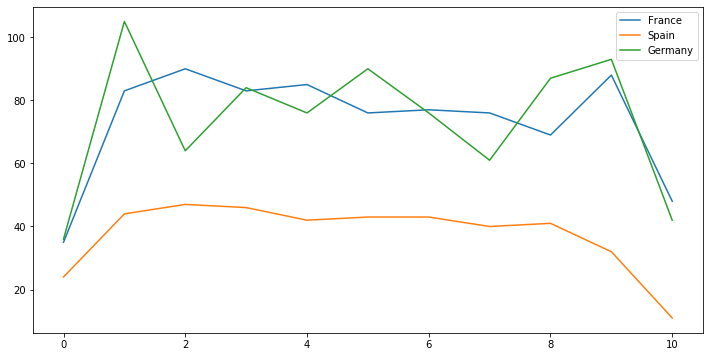

In [32]:
aux8 = df[(df['Geography']=='France')]
aux8 = aux8[['Exited', 'Tenure']].groupby('Tenure').sum()

aux9 = df[(df['Geography']=='Spain')]
aux9 = aux9[['Exited', 'Tenure']].groupby('Tenure').sum()

aux10 = df[(df['Geography']=='Germany')]
aux10 = aux10[['Exited', 'Tenure']].groupby('Tenure').sum()

plt.figure(figsize=(12,6))
plt.plot(aux8, label="France")
plt.plot(aux9, label='Spain')
plt.plot(aux10, label='Germany')
plt.gca().legend(('France','Spain', 'Germany'));

- Clientes de França e Alemanha aumentam muito a taxa de Churn do primeiro para o segundo ano.

## 4.2 - Analise Bivariada

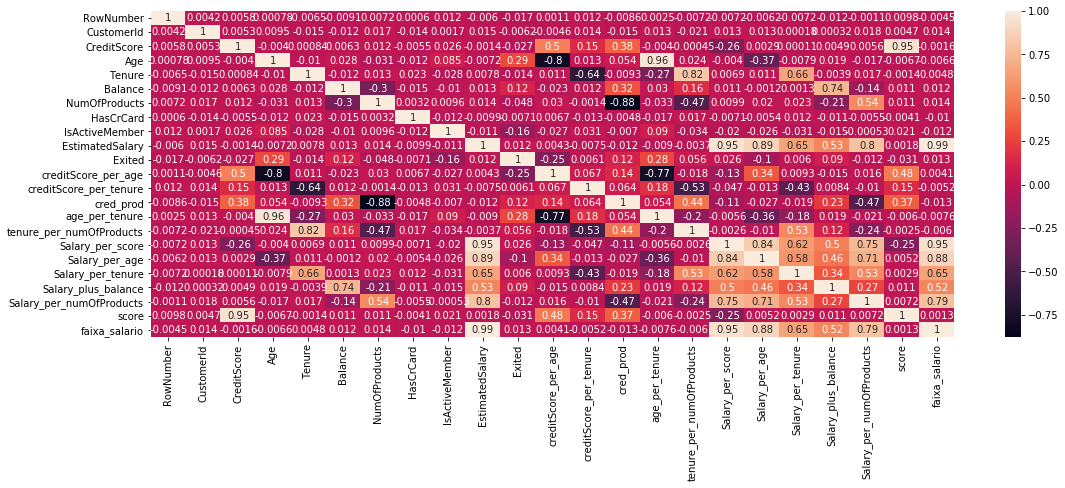

In [33]:
corr = df.corr()
plt.figure(figsize=(18,6))
sns.heatmap(corr, annot=True);

## 4.3 - Analise Multivariada

**H1 - Consumidores Alemães entram 10% mais em Churn do que os consumidores de outros países.** 

**Verdadeiro** - Em média, os alemães entram 15% a mais em churn do que consumidores de outros países. 

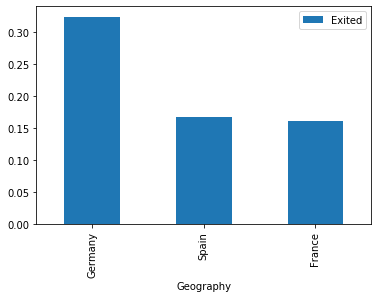

In [34]:
aux1 = df[['Geography','Exited']].groupby('Geography').mean().sort_values(by=['Exited'], ascending=False)
aux1.plot.bar();

**H2 - Consumidoras mulheres entram mais em Churn do que os consumidores Homens.** 

**Verdadeiro** - Percentualmente mais mulheres entram em churn do que homens.

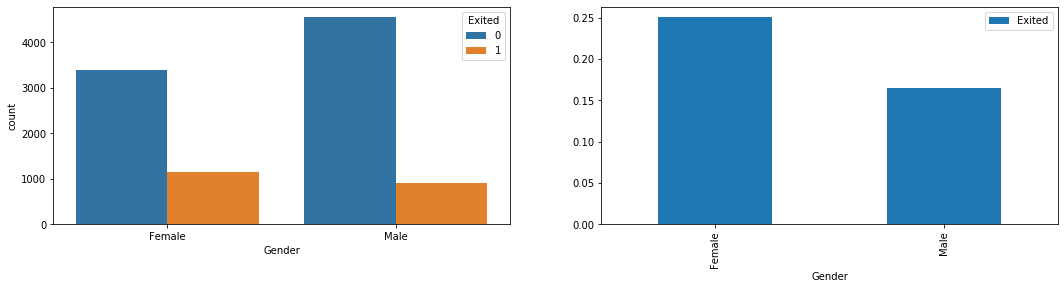

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.countplot(x='Gender', hue='Exited', data=df, ax=ax[0])

aux2 = df[['Gender','Exited']].groupby('Gender').mean().sort_values(by=['Exited'], ascending=False)
aux2.plot.bar(ax=ax[1]);


**H3 - Consumidores Alemães tem um valor maior que 10% em média em sua conta a mais que clientes de outros países** 

**Verdadeiro** - Os Alemães tem em média o dobro do valor em sua conta do que clientes de outros países.

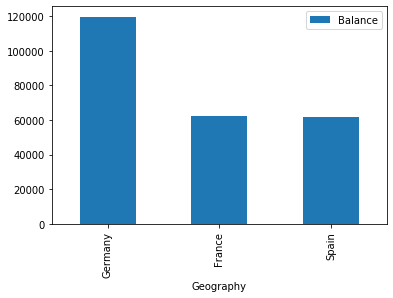

In [36]:
aux3 = df[['Geography','Balance']].groupby('Geography').mean().sort_values(by=['Balance'], ascending=False)
aux3.plot.bar();

**H4 - Consumidores com mais CreditScore entram em churn 10% a menos do que consumidores com menos CreditScore.**

**Falso** - Consumidores com mais CreditScore tem mais ou menos a mesma média de churn. Uma coisa interessante há se notar é que clientes com CreditScore de 350 até 450 tem 10% de chance a mais de entrar em Churn. 

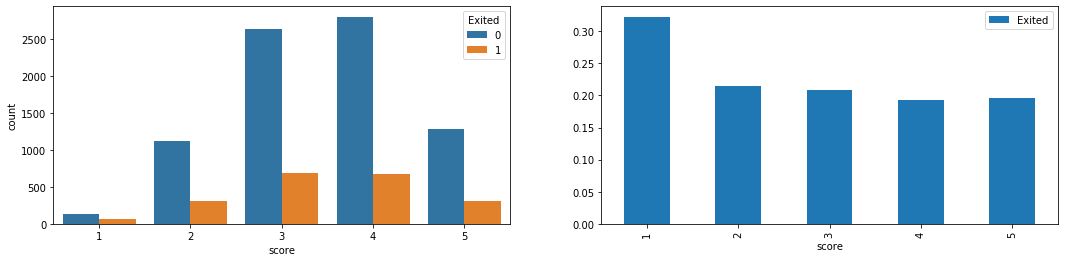

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.countplot(x='score', hue='Exited', data=df, ax=ax[0])

aux4 = df[['score', 'Exited']].groupby('score').mean()
aux4.plot.bar(ax=ax[1]);

**H5 - Clientes jovens entram em churn 50% a mais em média do que os demais clientes.**

**Falso** - Clientes de meia idade tem mais propensão para entrar em churn do que os demais clientes.

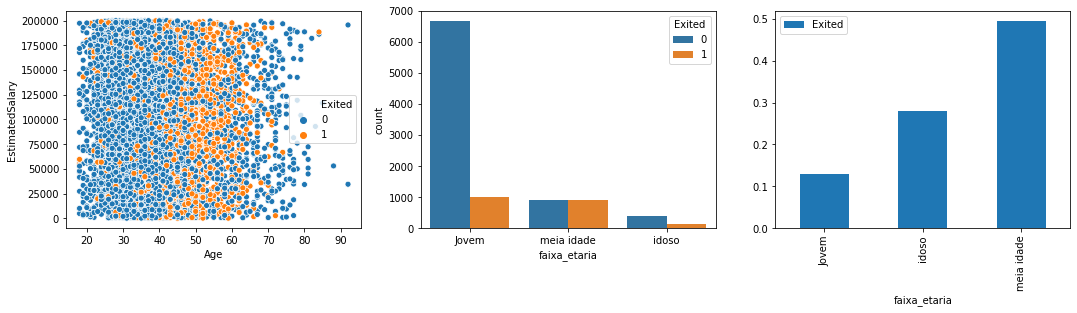

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))

sns.scatterplot(x='Age',y='EstimatedSalary', hue='Exited', data=df, ax=ax[0] )

sns.countplot(x='faixa_etaria', hue='Exited', data=df, ax=ax[1])

aux4= df[['faixa_etaria', 'Exited']].groupby('faixa_etaria').mean()
aux4.plot.bar(ax=ax[2]);

**H6 - Clientes ativos por mais tempo costumam ter mais dinheiro em conta.**

**Falso** - Quanto mais tempo os clientes ficam ativos, menos dinheiro eles tem em conta. Clientes ativos por mais tempo tem os maiores salários.

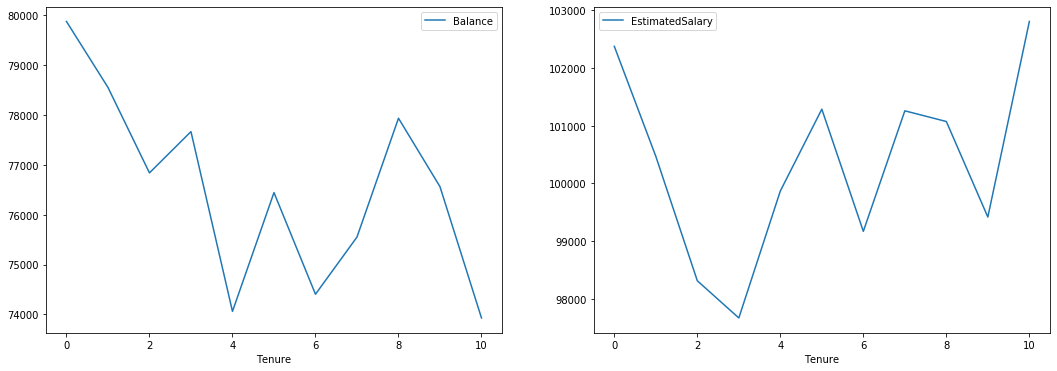

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

aux5 = df[['Balance', 'Tenure']].groupby('Tenure').mean()
aux5.plot(ax=ax[0])

aux6 = df[['EstimatedSalary', 'Tenure']].groupby('Tenure').mean()
aux6.plot(ax=ax[1]);

**H7 - Clientes com menores salários entram 10% a mais em Churn do que clientes com maiores salários.**

**Falso** - Independente do salário, os clientes entram em Churn.

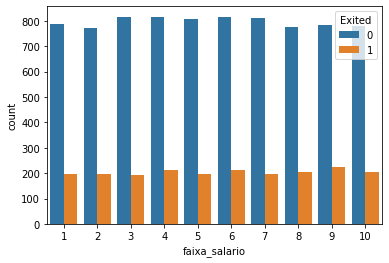

In [40]:
sns.countplot(x='faixa_salario', hue='Exited', data=df);

**H8 - Quanto maior o salário, maior o Score.**

**Falso** - Existem clientes com salário baixo e score alto.

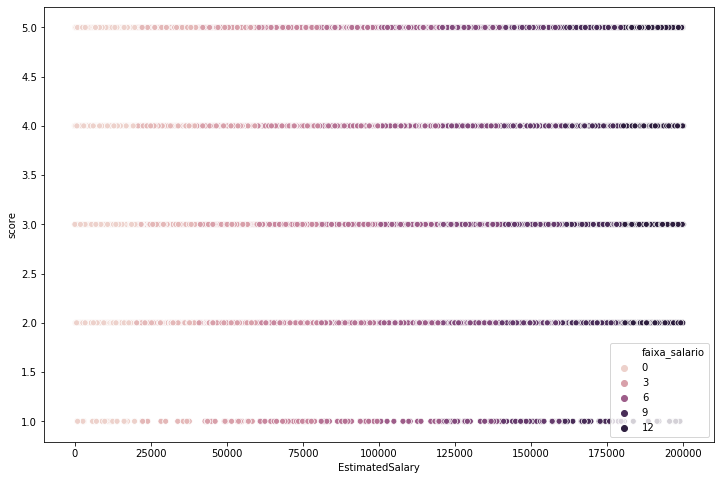

In [41]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='EstimatedSalary',y='score', hue='faixa_salario', data=df);

**H9 - Quem tem mais produtos contratos entram mais em Churn.**

**Verdadeiro** - Em Média, clientes que tem mais produtos tem mais chances de entrar em Churn.

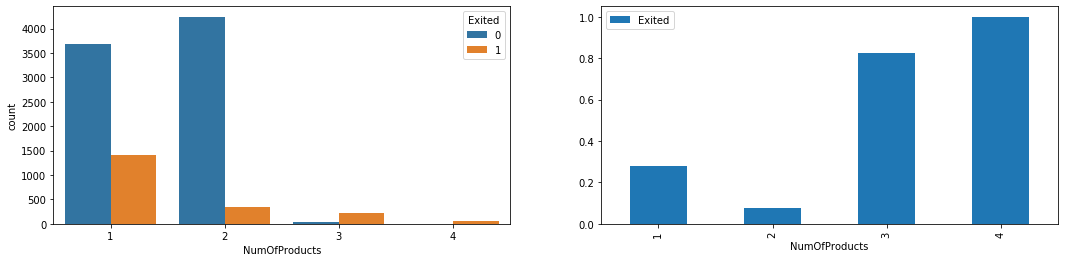

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=ax[0])

aux11 = df[['NumOfProducts', 'Exited']].groupby('NumOfProducts').mean()
aux11.plot.bar(ax=ax[1]);

# 5.0 Preparação dos dados

In [43]:
df_cat_col.head()

,Surname,Geography,Gender,faixa_etaria
0,Hargrave,France,Female,Jovem
1,Hill,Spain,Female,Jovem
2,Onio,France,Female,Jovem
3,Boni,France,Female,Jovem
4,Mitchell,Spain,Female,Jovem


In [44]:
df_cat_col = df_cat_col.drop('Surname', axis=1)

In [45]:
df_cat_col1 = pd.get_dummies(df_cat_col, drop_first=False)
df2 = pd.concat([df_cat_col1, df_num_col], axis=1)
df2.columns

Index(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'faixa_etaria_Jovem',
       'faixa_etaria_idoso', 'faixa_etaria_meia idade', 'RowNumber',
       'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'creditScore_per_age', 'creditScore_per_tenure', 'cred_prod',
       'age_per_tenure', 'tenure_per_numOfProducts', 'Salary_per_score',
       'Salary_per_age', 'Salary_per_tenure', 'Salary_plus_balance',
       'Salary_per_numOfProducts', 'score', 'faixa_salario'],
      dtype='object')

In [46]:
df3 = df2.drop(['RowNumber', 'CustomerId'], axis=1)

In [47]:
df3.columns

Index(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'faixa_etaria_Jovem',
       'faixa_etaria_idoso', 'faixa_etaria_meia idade', 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'creditScore_per_age',
       'creditScore_per_tenure', 'cred_prod', 'age_per_tenure',
       'tenure_per_numOfProducts', 'Salary_per_score', 'Salary_per_age',
       'Salary_per_tenure', 'Salary_plus_balance', 'Salary_per_numOfProducts',
       'score', 'faixa_salario'],
      dtype='object')

In [49]:
mm = MinMaxScaler()
rb = RobustScaler()

In [50]:
df4 = df3.copy()

In [51]:
df4.columns

Index(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'faixa_etaria_Jovem',
       'faixa_etaria_idoso', 'faixa_etaria_meia idade', 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'creditScore_per_age',
       'creditScore_per_tenure', 'cred_prod', 'age_per_tenure',
       'tenure_per_numOfProducts', 'Salary_per_score', 'Salary_per_age',
       'Salary_per_tenure', 'Salary_plus_balance', 'Salary_per_numOfProducts',
       'score', 'faixa_salario'],
      dtype='object')

In [52]:
df4.head()

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,faixa_etaria_Jovem,faixa_etaria_idoso,faixa_etaria_meia idade,CreditScore,Age,...,cred_prod,age_per_tenure,tenure_per_numOfProducts,Salary_per_score,Salary_per_age,Salary_per_tenure,Salary_plus_balance,Salary_per_numOfProducts,score,faixa_salario
0,1,0,0,1,0,1,0,0,619,42,...,619.000000,40,2.000000,163.730016,2413.068571,202697.76,0.000000e+00,101348.88,3,6
1,0,0,1,1,0,1,0,0,608,41,...,608.000000,40,1.000000,185.102928,2744.940976,112542.58,9.431953e+09,112542.58,3,6
2,1,0,0,1,0,1,0,0,502,42,...,167.333333,34,2.666667,226.955319,2712.656429,911452.56,1.819041e+10,341794.71,2,6
3,1,0,0,1,0,1,0,0,699,39,...,349.500000,38,0.500000,134.229800,2405.811026,93826.63,0.000000e+00,187653.26,4,5
4,0,0,1,1,0,1,0,0,850,43,...,850.000000,41,2.000000,93.040118,1839.165116,158168.20,9.925910e+09,79084.10,5,4


In [53]:
df4['CreditScore'] = mm.fit_transform(df4[['CreditScore']].values)

df4['Age'] = mm.fit_transform(df4[['Age']].values)

df4['Balance'] = rb.fit_transform(df4[['Balance']].values)

#df4['EstimatedSalary'] = rb.fit_transform(df4[['EstimatedSalary']].values)

df4['creditScore_per_age'] = rb.fit_transform(df4[['creditScore_per_age']].values)

df4['creditScore_per_tenure'] = rb.fit_transform(df4[['creditScore_per_tenure']].values)

df4['cred_prod'] = rb.fit_transform(df4[['cred_prod']].values)

df4['age_per_tenure'] = mm.fit_transform(df4[['age_per_tenure']].values)

df4['Salary_per_score'] = rb.fit_transform(df4[['Salary_per_score']].values)

df4['Salary_per_age'] = rb.fit_transform(df4[['Salary_per_age']].values)

df4['Salary_per_tenure'] = rb.fit_transform(df4[['Salary_per_tenure']].values)

df4['Salary_plus_balance'] = mm.fit_transform(df4[['Salary_plus_balance']].values)

df4['Salary_per_numOfProducts'] = rb.fit_transform(df4[['Salary_per_numOfProducts']].values)

# 6.0 - Escolha de variavéis

In [54]:
df4.head()

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,faixa_etaria_Jovem,faixa_etaria_idoso,faixa_etaria_meia idade,CreditScore,Age,...,cred_prod,age_per_tenure,tenure_per_numOfProducts,Salary_per_score,Salary_per_age,Salary_per_tenure,Salary_plus_balance,Salary_per_numOfProducts,score,faixa_salario
0,1,0,0,1,0,1,0,0,0.538,0.324324,...,0.533333,0.385542,2.000000,0.060902,-0.046094,-0.273195,0.000000,-0.229651,3,6
1,0,0,1,1,0,1,0,0,0.516,0.310811,...,0.500000,0.385542,1.000000,0.201687,0.078513,-0.416504,0.227178,-0.147275,3,6
2,1,0,0,1,0,1,0,0,0.304,0.324324,...,-0.835354,0.313253,2.666667,0.477372,0.066391,0.853429,0.438133,1.539807,2,6
3,1,0,0,1,0,1,0,0,0.698,0.283784,...,-0.283333,0.361446,0.500000,-0.133419,-0.048819,-0.446254,0.000000,0.405469,4,5
4,0,0,1,1,0,1,0,0,1.000,0.337838,...,1.233333,0.397590,2.000000,-0.404738,-0.261577,-0.343978,0.239075,-0.393499,5,4


In [55]:
X = df4.drop(['Exited'], axis=1)
y = df4['Exited']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, stratify=y)
X_test_df = X_test.copy()

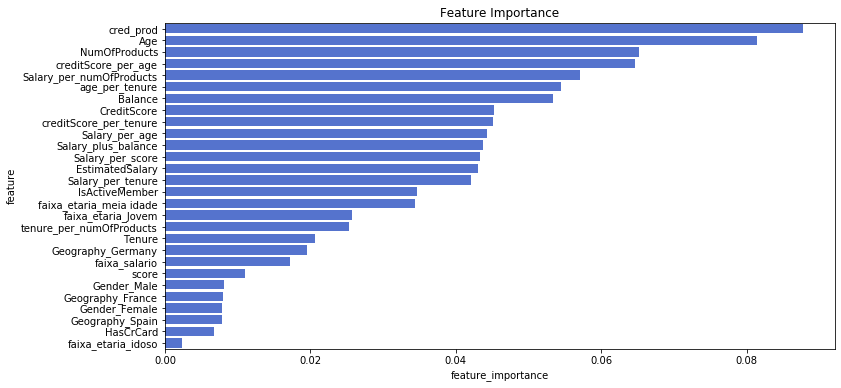

In [57]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [58]:
X_train = X_train[['Age', 'Balance','cred_prod','NumOfProducts', 'creditScore_per_age', 'Salary_per_numOfProducts',
                   'age_per_tenure', 'CreditScore', 'creditScore_per_tenure',
                   'Salary_per_tenure', 'Salary_per_score', 'Salary_per_age']]

In [59]:
X_test = X_test[['Age', 'Balance','cred_prod','NumOfProducts', 'creditScore_per_age', 'Salary_per_numOfProducts',
                   'age_per_tenure', 'CreditScore', 'creditScore_per_tenure',
                   'Salary_per_tenure', 'Salary_per_score', 'Salary_per_age']]

# 7.0 - Machine Learning

In [60]:
kfold = StratifiedKFold(n_splits=5, random_state=1)

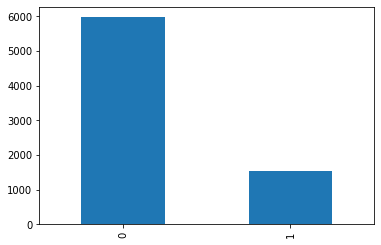

In [61]:
aux12 = y_train.value_counts()
aux12.plot.bar();

In [62]:
sm = SMOTE()
nm = NearMiss()

In [63]:
X_train, y_train = sm.fit_sample(X_train, y_train)

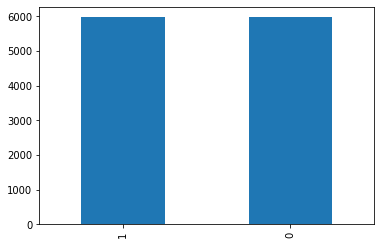

In [65]:
aux12 = y_train.value_counts()
aux12.plot.bar();

In [66]:
du = DummyClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
etx = ExtraTreesClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xbc = XGBClassifier()

## 7.1.1 Dummy - Classificador Aleatório

In [67]:
du_result = ml_error('Dummy Classifier', du)
du_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Dummy Classifier,0.494726,0.49472,0.496145,0.492635,0.496471


## 7.1 Regressão Logística 

In [68]:
lr_result = ml_error('Regressão Logistica',lr)
lr_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Regressão Logistica,0.738531,0.724635,0.769427,0.804528,0.790223


## 7.2 DecisionTreeClassifier

In [69]:
dtc_result = ml_error('DecisionTreeClassifier',dtc)
dtc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,DecisionTreeClassifier,0.820247,0.816083,0.826165,0.820228,0.761698


## 7.3 - ExtraTreesClassifier

In [70]:
etx_result = ml_error('ExtraTreesClassifier',etx)
etx_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,ExtraTreesClassifier,0.878601,0.859007,0.90606,0.952545,0.95405


## 7.4 - RandonForestClassifier

In [71]:
rfc_result = ml_error('RandomForestClassifier',rfc)
rfc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,RandomForestClassifier,0.87048,0.85864,0.887464,0.944219,0.941331


## 7.5 - GradientBoostingClassifier

In [72]:
gbc_result = ml_error('GradientBoostingClassifier',gbc)
gbc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,GradientBoostingClassifier,0.808023,0.807915,0.807423,0.887789,0.889038


## 7.6 - XgBoost

In [73]:
xbc_result = ml_error('XGBClassifier',xbc)
xbc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,XGBClassifier,0.874837,0.893174,0.850766,0.949541,0.950233


## 7.7 - Comparação de Modelos

In [74]:
modelling_result = pd.concat([du_result, lr_result,dtc_result,etx_result,rfc_result,gbc_result,xbc_result])
modelling_result.sort_values('Precision', ascending=False)

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,XGBClassifier,0.874837,0.893174,0.850766,0.949541,0.950233
0,ExtraTreesClassifier,0.878601,0.859007,0.906060,0.952545,0.954050
0,RandomForestClassifier,0.870480,0.858640,0.887464,0.944219,0.941331
0,DecisionTreeClassifier,0.820247,0.816083,0.826165,0.820228,0.761698
0,GradientBoostingClassifier,0.808023,0.807915,0.807423,0.887789,0.889038
0,Regressão Logistica,0.738531,0.724635,0.769427,0.804528,0.790223
0,Dummy Classifier,0.494726,0.494720,0.496145,0.492635,0.496471


# 8.0 - Hyper Tunning

## 8.1 - Parametros Grid

In [75]:
param_grid = [{'max_depth':[2,4,6,8], 'criterion':['gini', 'entropy'], 'ccp_alpha':[0.0, 0.1, 0.5, 0.8,1]}]
grid = GridSearchCV(etx, param_grid, cv=kfold)
grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                               

In [76]:
grid.best_params_

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 8}

## 8.2 - Modelo Tunado

In [77]:
etx = ExtraTreesClassifier(criterion='gini', max_depth=8, ccp_alpha=0.0)

In [78]:
etx.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=8, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [79]:
y_pred = etx.predict(X_test)

## 8.3 Confusion Matrix - Modelo Aleatório (DummyClassifier)

In [80]:
du.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='warn')

In [81]:
y_pred_dummy = du.predict(X_test)

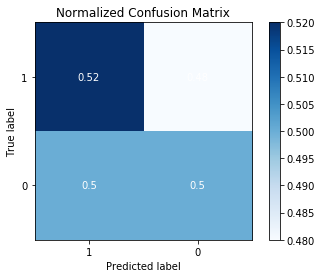

In [115]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dummy,normalize=True,labels=[1,0]);

In [113]:
recall_dummy = recall_score(y_test, y_pred_dummy).round(2)*100
precision_dummy = precision_score(y_test, y_pred_dummy).round(2)*100

print("De todos os Clientes que foi previsto que entrariam em Churn, o modelo acertou:", precision_dummy, '%')
print("De todos os Clientes que efetivamente entraram em Churn, o modelo acertou:", recall_dummy, '%')

De todos os Clientes que foi previsto que entrariam em Churn, o modelo acertou: 21.0 %
De todos os Clientes que efetivamente entraram em Churn, o modelo acertou: 52.0 %


## 8.4 Confusion Matrix - Modelo

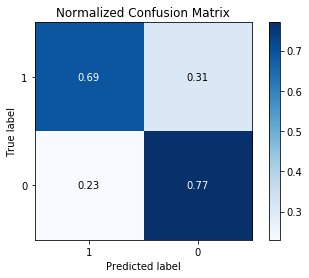

In [116]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred,normalize=True,labels=[1,0]);

In [111]:
recall_etx = recall_score(y_test, y_pred).round(2)*100
precision_etx = precision_score(y_test, y_pred).round(2)*100

print("De todos os Clientes que foi previsto que entrariam em Churn, o modelo acertou:", precision_etx, '%')
print("De todos os Clientes que efetivamente entraram em Churn, o modelo acertou:", recall_etx, '%')


De todos os Clientes que foi previsto que entrariam em Churn, o modelo acertou: 43.0 %
De todos os Clientes que efetivamente entraram em Churn, o modelo acertou: 69.0 %


## 9.0 Model and Business Performance

In [84]:
# Criação do DataFrame de Acertos

X_test_df = X_test_df['EstimatedSalary'].reset_index()

y_pred_df = pd.DataFrame(y_pred)

y_test_df = y_test.reset_index()

business = pd.concat([y_test_df, y_pred_df, X_test_df],axis=1)

business.columns = ['Index1', 'Exited', 'Previsao', 'Index2', 'Salario']

business = business[['Exited', 'Previsao', 'Salario']]

business_acertos = business[(business['Exited']==1) & (business['Previsao']==1)]

## 9.2 - Média de Salário de Todos os Clientes do TopBank

In [85]:
media_salario = df['EstimatedSalary'].mean()

media_salario = round(media_salario,2)

print('A média de salário dos clientes é: R$', media_salario)

A média de salário dos clientes é: R$ 100090.24


## 9.3 - Retorno esperado

In [87]:
retorno_esperado = 0
for i in business_acertos['Salario']:
    if i >= media_salario:
        retorno_esperado = retorno_esperado + (i * 0.20)
    else:
        retorno_esperado = retorno_esperado + (i * 0.15)
        
retorno_esperado = round(retorno_esperado,2)

print('O retorno esperado caso consigamos reter esses clientes que acertamos que iriam entrar em Churn é: R$', 
      retorno_esperado)

O retorno esperado caso consigamos reter esses clientes que acertamos que iriam entrar em Churn é: R$ 6834152.88


## 9.4 - Performance do Mododelo

### Modo Aleatório

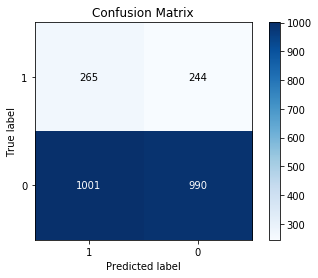

In [91]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dummy,normalize=False,labels=[1,0]);

### Com um modelo de Machine Learning

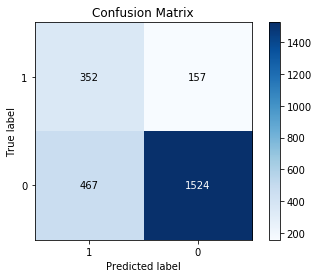

In [112]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred,normalize=False,labels=[1,0]);

- Com um modelo de Machine Learning é possível prever 69% dos clientes que efetivamente entrariam em Churn. 
- De forma Aleatória seria 50%.


- Com um modelo de Machine Learning eu daria incentivos Financeiros corretamente para 43% dos clientes.
- De forma aleatória seria para 21%.
- Dar incentivos financeiros para quem de fato tem mais chances de entrar em Churn é essencial pois evita o uso desnecessário de recursos do Banco. (Em nosso exemplo, nosso modelo evitaria desse gasto de recurso com 447 clientes).



## Próximos Passos

Desenvolver um modelo de Pesquisa Operacional para verificar a forma ótima de dar incentivos financeiros a esses clientes. 